## Лабораторная работа №8. Рекуррентные нейронные сети для анализа временных рядов
Данные: Набор данных для прогнозирования временных рядов, который состоит из среднемесячного числа пятен на солнце, наблюдаемых с января 1749 по август 2017. 
Данные в виде csv-файла можно скачать на сайте Kaggle -> https://www.kaggle.com/robervalt/sunspots/


#### Задание 1.
Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).


In [59]:
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
import numpy as np

k = 'Date'
v = 'Monthly Mean Total Sunspot Number'
data_folder = '../data'

epochs = 200
batch_size = 32
steps = 10

In [2]:
df = pd.read_csv(data_folder + '/sunspots/Sunspots.csv', parse_dates=[0], usecols=[1, 2])


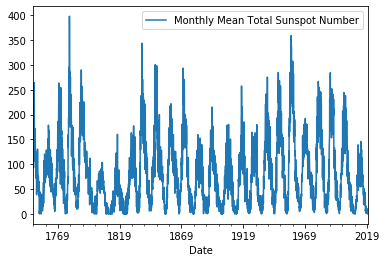

In [3]:
df.plot(x = k, y = v)


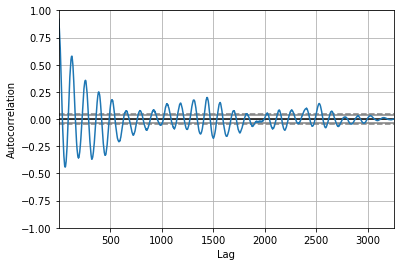

In [4]:
pd.plotting.autocorrelation_plot(df[v])


#### Задание 2.
Для прогнозирования разделите временной ряд на обучающую, валидационную и контрольную выборки.


In [5]:
train_df, test_df = train_test_split(df, shuffle=False)
train_df, dev_df = train_test_split(train_df, shuffle=False)


#### Задание 3.
Примените модель ARIMA для прогнозирования значений данного временного ряда.


In [6]:
model = ARIMA(train_df[v], (5, 0, 3), dates=train_df[k])


results = model.fit()
predictions = results.forecast(steps=len(dev_df))[0]


/home/yalov4uk/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


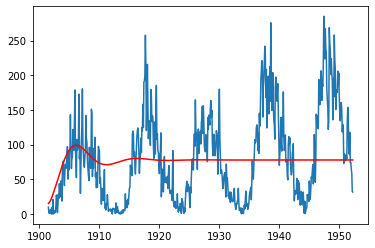

In [7]:
plt.plot(dev_df[k], dev_df[v])
plt.plot(dev_df[k], predictions, color='red')
pyplot.show()


#### Задание 4.
Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).


In [15]:
def split_sequence(sequence, steps):
    X, y = [], []
    for i in range(steps, len(sequence)):
        X.append(sequence.iloc[i - steps: i])
        y.append(sequence.iloc[i])
    return np.array(X), np.array(y).reshape((len(y), 1))



In [60]:
X_train, y_train = split_sequence(train_df[v], steps)
X_dev, y_dev = split_sequence(dev_df[v], steps)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_dev = X_dev.reshape((X_dev.shape[0], X_dev.shape[1], 1))


In [41]:
def model_factory():
    return keras.Sequential([
        keras.layers.LSTM(50, input_shape=X_train.shape[-2:], return_sequences=True),
        keras.layers.LSTM(50),
        keras.layers.Dense(1)
    ])


In [50]:
def train(model):
    model.compile(loss='mse', optimizer='adam')

    model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
              batch_size=batch_size)
    

In [61]:
model = model_factory()
train(model)


Train on 1819 samples, validate on 600 samples
Epoch 1/200
1819/1819 [==============================] - 4s 2ms/sample - loss: 9583.5419 - val_loss: 9188.5197
Epoch 2/200
1819/1819 [==============================] - 1s 616us/sample - loss: 8628.2316 - val_loss: 8621.2831
Epoch 3/200
1819/1819 [==============================] - 1s 766us/sample - loss: 8187.2086 - val_loss: 8207.8790
Epoch 4/200
1819/1819 [==============================] - 1s 789us/sample - loss: 7811.7770 - val_loss: 7824.4481
Epoch 5/200
1819/1819 [==============================] - 2s 893us/sample - loss: 7464.9919 - val_loss: 7464.8805
Epoch 6/200
1819/1819 [==============================] - 1s 803us/sample - loss: 7140.5018 - val_loss: 7136.1935
Epoch 7/200
1819/1819 [==============================] - 1s 706us/sample - loss: 6839.5597 - val_loss: 6821.1881
Epoch 8/200
1819/1819 [==============================] - 1s 818us/sample - loss: 6554.5236 - val_loss: 6526.1454
Epoch 9/200
1819/1819 [============================

In [62]:
predictions = model.predict(X_dev, verbose=4)


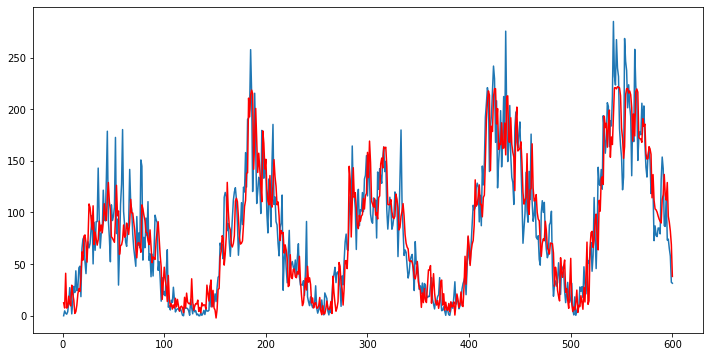

In [64]:
times=list(range(1,len(y_dev)+1))
plt.figure(figsize=(12,6))
plt.plot(times, y_dev)
plt.plot(times, predictions, color='red')
pyplot.show()
